In [1]:
using DifferentialEquations, ParameterizedFunctions, CairoMakie

vdp = @ode_def begin
    dx = (x - x^3/3 + y)/ϵ
    dy = (a-x)
end ϵ a

function vdpplot(u0,tspan,p)
    prob = ODEProblem(vdp, u0, tspan, p)
    sol = solve(prob,abstol=1e-12,reltol=1e-12)
    
    fig = Figure()
    ax = Axis(fig[1,1])
    
    lines!(ax, -2.5:.01:2.5, x->-x+x^3/3,label="x' = 0", color=:red)
    lines!(ax, ones(length(-1:.1:1))*p[2],-1:.1:1,  label="y' = 0", color=:green)
    lines!(ax,sol[1,:],sol[2,:],color=:blue)
    ylims!(-1,1)
    axislegend()

    fig,sol
end

canard_a = .99874045124555;

gsvf = @ode_def begin
    da = μ-a-a*b^2
    db = (-b+a+a*b^2)/ϵ
end ϵ μ

function gstr(u0,tspan,p)
    prob = ODEProblem(gsvf, u0, tspan, p)
    sol = solve(prob,abstol=1e-12,reltol=1e-12)
    sol
end


gstr (generic function with 1 method)

# Topics in multiple timescale dynamics, with applications - Day 3

### The autocatalator, and an introduction to canards

## I. Directional blowups


In order to facilitate working with vector fields on $S^n \times \mathbb{R}$, it will be convenient to introduce _charts_ that cover the space and on which the blowup map takes an especially simple form. This precisely amounts to passing to the standard affine coordinate charts on projective space in algebraic geometry.

We define the chart $K_{i, \pm} : \mathbb{R}^{n+1} \to S^n \times \mathbb{R}$ as $$K_{i, \pm} (x_0, x_1, x_2, \cdots, x_{i-1}, r_i, x_{i+1}, \cdots, x_n) = \left(\frac{x_0}{q_{i}}, \frac{x_1}{q_{i}}, \cdots,\pm \frac{1}{q_i}, \cdots, \frac{x_{n}}{q_{i}}, r_i q_i \right)$$ where $q_i = \sqrt{1 + \sum_{k\neq i} x_{k}^2}$. This slightly messy formula is a modification of the standard coordinate chart on $S^n$ that one obtains when projecting a hemisphere in the $i$th coordinate direction (i.e. $S^n \cap \{\pm x_i > 0\}$) radially onto the hyperplane $x_i = \pm 1$.

The more important fact is that in these charts, the blowup map takes an especially simple form, namely we have the **directional blowup maps** $\Psi_{i, \pm} := \Psi \circ K_{i, \pm}$ given by $$\Psi_{i, \pm} (x_0, x_1, \cdots, r_i, \cdots, x_n) = (r_i x_0, r_i x_1, \cdots, \pm r_i, \cdots, r_i x_n)$$ This is exactly the map obtained by setting $x_i = \pm 1$ in the standard blowup map.



### Example:

Let's write down the polar blowup $\Psi: S^1 \times \mathbb{R} \to \mathbb{R}^2$ in coordinate charts. We can cover $\mathbb{R}^2$ using the images of just two charts: $K_{1, +}, K_{2,+} : \mathbb{R}^2 \to S^1 \times \mathbb{R}$ given by $$K_{1, +} (r_1, y_1) = \left(\frac{1}{\sqrt{1+y_{1}^2}}, \frac{y_1}{\sqrt{1+y_{1}^2}}, r_1 \sqrt{1+y_{1}^2} \right)$$

$$K_{2, +} (x_2, r_2) = \left(\frac{x_2}{\sqrt{1+x_{2}^2}}, \frac{1}{\sqrt{1+x_{2}^2}}, r_2 \sqrt{1+x_{2}^2} \right)$$ 

* Note carefully that each chart sends the $r = 0$ axis to an arc of $S^1$ in the blownup locus, with $K_{1,+}$ covering the right hemisphere of $S^1$ and $K_{2,+}$ covering the upper hemisphere of $S^1$. 

* These two charts do _not_ cover the entirety of the blownup space $S^1 \times \mathbb{R}$; in particular, the lower and left hemispheres of the circle, crossed with $\{0\} \subset \mathbb{R}$, are not in the image.

* However, for the Gucwa/Szmolyan autocatalator example, recall that the state variables $a, b \ge 0$. So in this case, just two charts will turn out to suffice.

## II. Back to the autocatalator: heuristic analysis

* Recall that we are studying the dynamics of the planar ODE given by $$\dot{a} = \mu - a - ab^2$$ $$\epsilon \dot{b} = -b + a + ab^2$$ Last time, we identified $a$ as the slow variable and $b$ as the fast variable. The critical manifold is $$C_0 = \{(a,b) \, : \, -b + a + ab^2 = 0 \} = \left\{(a,b) \, : \, a = \frac{b}{1+b^2} \right \}$$ and there is a nondegenerate fold point at $p_{f} = (1/2, 1)$.

* Trajectories of the fast subsystem are parallel to the $b$-axis. The lower branch $S_{a}$ of the critical manifold is attracting, and the upper branch $S_{r}$ is repelling.

* Trajectories of the slow subsystem live on the critical manifold. For $\mu > 1$, there is a unique repelling equilibrium for the slow subsystem at $b = \mu$.

* Thus, a candidate trajectory consists of the lower branch $S_a$ concatenated with the fast fiber at $a = 1/2$. In particular, we expect the trajectory to jump to infinity.

* **However**, in simulations it appears to exhibit oscillations! What did we miss? How does the trajectory get back to the origin?

In [25]:
using CairoMakie, FileIO

img1 = rotr90(load(assetpath("/home/sameer/Documents/Summer 2021/gspt course/day3/gucwa1.png")))
img2 = rotr90(load(assetpath("/home/sameer/Documents/Summer 2021/gspt course/day3/gucwa2.png")))
fig = Figure(resolution = (1500,1000))
ax1 = Axis(fig[1, 1], aspect = DataAspect())
ax2 = Axis(fig[1, 2], aspect = DataAspect())
image!(ax1,img1)
image!(ax2,img2)
;

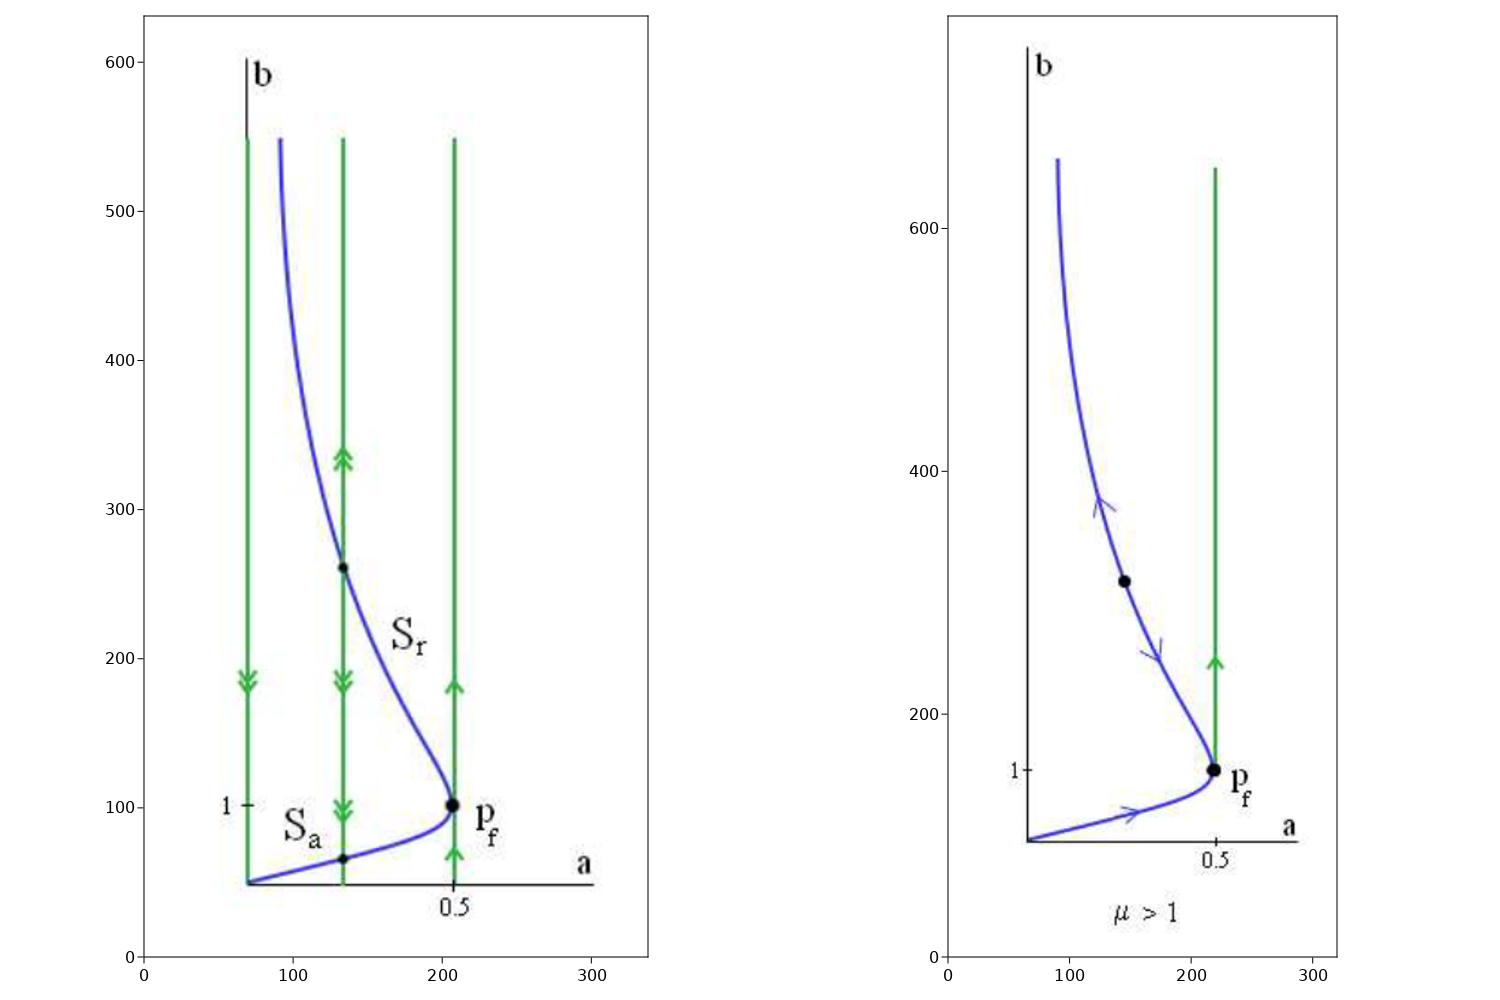

In [26]:
fig

### Existence of an additional timescale

* The GSPT analysis is only valid while $a$ and $b$ remain _bounded_ (and thus we call it the $b = \mathcal{O}(1)$ regime). If there are portions of the trajectory where $b = \mathcal{O}(1/\epsilon)$, then taking $\epsilon \to 0$ will not result in the layer problem.

* _Clever idea of Gucwa and Szmolyan:_ change variables according to $$a = A$$ $$b = \frac{B}{\epsilon}$$ $$T = \frac{t}{\epsilon^2}$$ We can interpret this as rescaling to display the dynamics when $b$ is in the regime $\mathcal{O}(1/\epsilon)$, on a "superslow" timescale $T$.

* With this change of variables, the equations of the autocatalator read $$\frac{dA}{dT} = \mu \epsilon^2 - A \epsilon^2 - AB^2$$ $$\frac{dB}{dT} = -B\epsilon + A \epsilon^2 + AB^2$$ Again, note that for $\epsilon \neq 0$ these are precisely equivalent to the original system.

* Now, setting $\epsilon = 0$ gives $$\frac{dA}{dT} = -AB^2$$ $$\frac{dB}{dT} = AB^2$$ This can be thought of as a layer problem on the superslow timescale.

* In this layer problem, the $A$- and $B$-axes are both comprised wholly of equilibria. We call these lines of equilibria $\ell_{A}$ and $\ell_{B}$ respectively. 

* Note that any compact submanifold of $\ell_{B}$ not including the origin is normally hyperbolic, and thus away from the origin $\ell_{B}$ perturbs nicely to a slow manifold via Fenichel theory.

* However, $\ell_{A}$ consists entirely of nonhyperbolic equilibria.

* Furthermore, $A+B$ is a conserved quantity of the system. This suggests (and it is straightforward to show that) for each $(A_0, 0) \in \ell_{A}$ and $(0, A_0) \in \ell_{B}$, there is a heteroclinic orbit connecting these two equilibria.

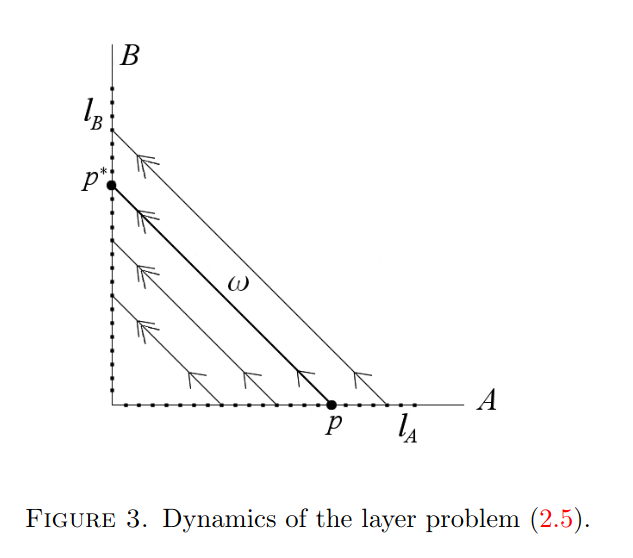

* This explains why the trajectory very slowly (i.e. on the superslow timescale) drifts towards the $B$-axis. But how does it then return to the origin to complete the oscillation?

* By Fenichel theory, we know $\ell_{B}$ perturbs to a slow manifold. Suppose the graph of the slow manifold is given by $A = h(B, \epsilon)$. We can compute that $$h(B, \epsilon) = \epsilon^2 \frac{\mu}{B^2} + \mathcal{O}(\epsilon^3)$$ Substituting this expression into the full system, we obtain $$\frac{dB}{d\tau} = -B + O(\epsilon)$$ Thus, once the trajectory is near the slow manifold, the $B$-coordinate decays exponentially on the slow (not superslow) timescale.

* Note that if $b$ is bounded, then as $\epsilon \to 0$, we have $B \to 0$. Thus, the entirety of the $b = \mathcal{O}(1)$ regime gets compressed into the nonhyperbolic line of equilibria $\ell_{A}$. In particular, the fold point $(1/2, 1)$ is smushed into $(1/2, 1)$.

* This picture suggests a candidate trajectory $\gamma_{0}$ that explains the observed global oscillations: traverse $\ell_{A}$ from the origin to $(1/2, 0)$, then a heteroclinic orbit joining to  $\ell_{B}$, and finally return to the origin along $\ell_{B}$.

* But how do we make this precise? In passing to the superslow timescale, we have apparently lost all information about the $\mathcal{O}(1)$ regime.

**Answer:** blow up the line of equilibria $\ell_{A}$ to a cylinder!


## III. The autocatalator: blowing up $\ell_{A}$

* We will describe how Gucwa and Szmolyan use a blowup to recover dynamics in the $b = \mathcal{O}(1)$ regime from the nonhyperbolic line of equilibria $\ell_{A}$. Essentially, this regime is discovered to live on the blown up cylinder, where the appropriate component pieces are actually _hyperbolic_. With some additional analysis on the blown up locus, they are able to construct a contracting Poincare map. Using the contraction mapping principle, this enables them to prove:

**Theorem (Gucwa/Szmolyan 2008):** For $\mu > 1$ and $\epsilon$ sufficiently small, there is a unique attracting periodic orbit $\gamma_{\epsilon}$ of the autocatalator, which tends to the singular cycle $\gamma_{0}$ as $\epsilon \to 0$.


* Their analysis begins with the rescaled extended system $$A' = \mu \epsilon^2 - A\epsilon^2 - AB^2$$ $$B' = -\epsilon B + A\epsilon^2 + AB^2$$ $$\epsilon' = 0$$ i.e. we view the parameter $\epsilon$ as a third variable. In this reformulation, the planes $\epsilon = \text{const.}$ are invariant under the flow, and on the plane $\epsilon = 0$ we recover the superslow layer problem.


* To blow up the $A$-axis $\ell_{A}$, we consider the map $\Psi : \mathbb{R} \times S^1 \times \mathbb{R} \to \mathbb{R} \times \mathbb{R}^2$ given by $$\Psi(\overline{a}, (\overline{b}, \overline{\epsilon}), r) = (\overline{a}, r \overline{b}, r \overline{\epsilon})$$ where $\overline{b}^2 + \overline{\epsilon}^2 = 1$. This is the polar blowup in the $B$, $\epsilon$ directions for each plane $A = \text{const.}$.

* Now we have two directional charts $K_1, K_2: \mathbb{R} \times \mathbb{R}^2 \to \mathbb{R} \times S^1 \times \mathbb{R}$ defined as above; $K_1$ covers the part of $S^1$ with $\overline{\epsilon} > 0$ and $K_2$ covers the part with $\overline{b} > 0$. Explicitly, the charts are $$K_1 (a_1, b_1, r_1) = \left(a_1, \frac{b_1}{\sqrt{1+b_{1}^2}}, \frac{1}{\sqrt{1+b_{1}^2}}, r_1 \sqrt{1+b_{1}^2} \right)$$ and $$K_2 (a_2, r_2, \epsilon_2) = \left( a_2, \frac{1}{\sqrt{1+\epsilon_{2}^{2}}}, \frac{\epsilon_{2}}{\sqrt{1+\epsilon_{2}^{2}}}, r_2 \sqrt{1+\epsilon_{2}^2} \right)$$

* Recalling that $\ell_{A}$ is exactly given by $B = 0$, we expect that $K_1$ will cover the $b = \mathcal{O}(1)$ regime and $K_2$ will cover the $b = \mathcal{O}(1/\epsilon)$ regime (since the image of $K_1$ contains $\overline{b} = 0$, $\overline{\epsilon} > 0$ and the image of $K_2$ contains $\overline{b} > 0$, $\overline{\epsilon} = 0$).

* In $K_1$, the blowup map is $$\Psi_{1} (a_1, b_1, r_1) = \Psi \circ K_1 =  (a_1, r_1 b_1, r_1)$$ and in $K_2$ the blowup map is $$\Psi_{2} (a_2, r_2, \epsilon_2) = \Psi \circ K_2 = (a_2, r_2, r_2 \epsilon_2)$$


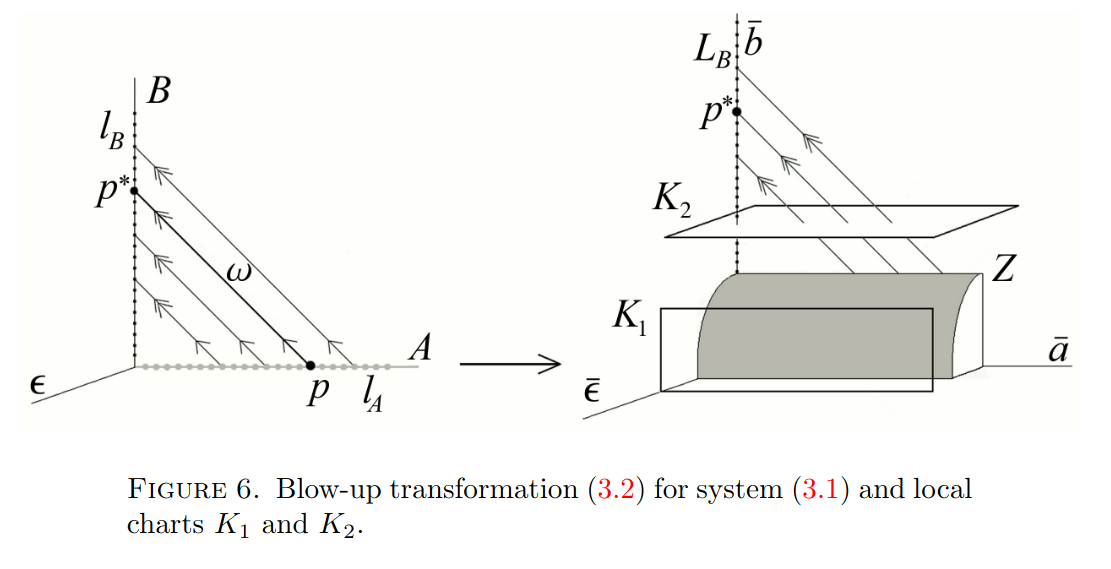

**Dynamics in chart $K_1$**

* After computing the vector field in $K_1$ and desingularizing, we find the dynamics $$a_1' = r_1 (\mu - a_1 - a_1 b_1^2)$$ $$b_1' = a_1 - b_1 + a_1 b_1^{2}$$ This is precisely the original system (prior to the superslow time rescaling). Thus, the GSPT analysis is valid on compact regions in this chart. The curve of equilibria $r_1 = 0$, $a_1 - b_1 + a_1 b_{1}^2 = 0$ lives on the cylinder.

**Dynamics in chart $K_2$**

* After computing the vector field in $K_2$ and desingularizing, we obtain $$a_{2}' = -r_2 (a_2 + \epsilon_{2}^2 a_2 - \epsilon_{2}^2 \mu)$$ $$r_{2}' = r_{2} (a_2 + \epsilon_{2}^2 - \epsilon_2)$$ $$\epsilon_{2}' = -\epsilon_{2} (a_2 + \epsilon_{2}^2 a_2 - \epsilon_{2})$$

* There are two invariant subspaces: $\epsilon_2 = 0$ and $r_2 = 0$. The plane $r_2 = 0$ maps to a piece of the cylinder (with $\overline{b} > 0$), while the plane $\epsilon_2 = 0$ maps to the (preimage of the) $A-B$ plane. Thus, these two planes connect the blown up locus with the $\mathcal{O}(1/\epsilon)$ regime.

* Indeed, in $\epsilon_2 = 0$, the dynamics reduce to $$a_{2}' = -a_{2} r_{2}$$ $$r_{2}' = a_{2} r_{2}$$ which has dynamics akin to the superslow layer problem but where both lines of equilibria $L_{A}$ and $L_{B}$ are _hyperbolic_.



* In $r_2 = 0$ the dynamics reduce to $$a_{2}' = 0$$ $$\epsilon_{2}' = -(a_2 + \epsilon_{2}^2 a_{2} - \epsilon_{2}) \epsilon_{2}$$ The equilibria here are the line $L_{A}$ and a curve $S$ corresponding to the same curve discovered in the $K_1$ chart. The repelling branch of $S$ admits heteroclinic orbits connecting $S$ to $L_{A}$. Thus, this picture "compactifies" the $\mathcal{O}(1)$-regime.


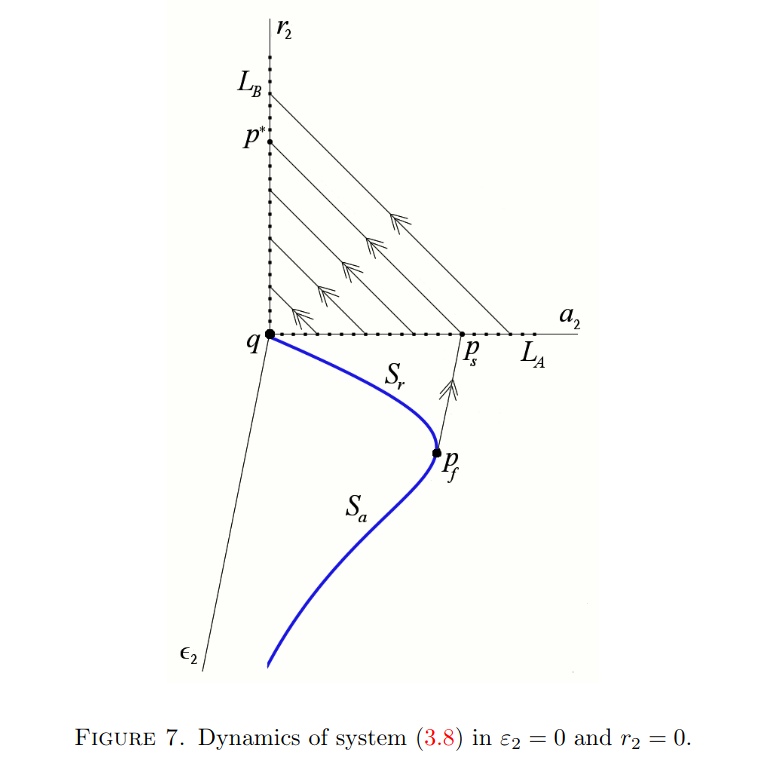

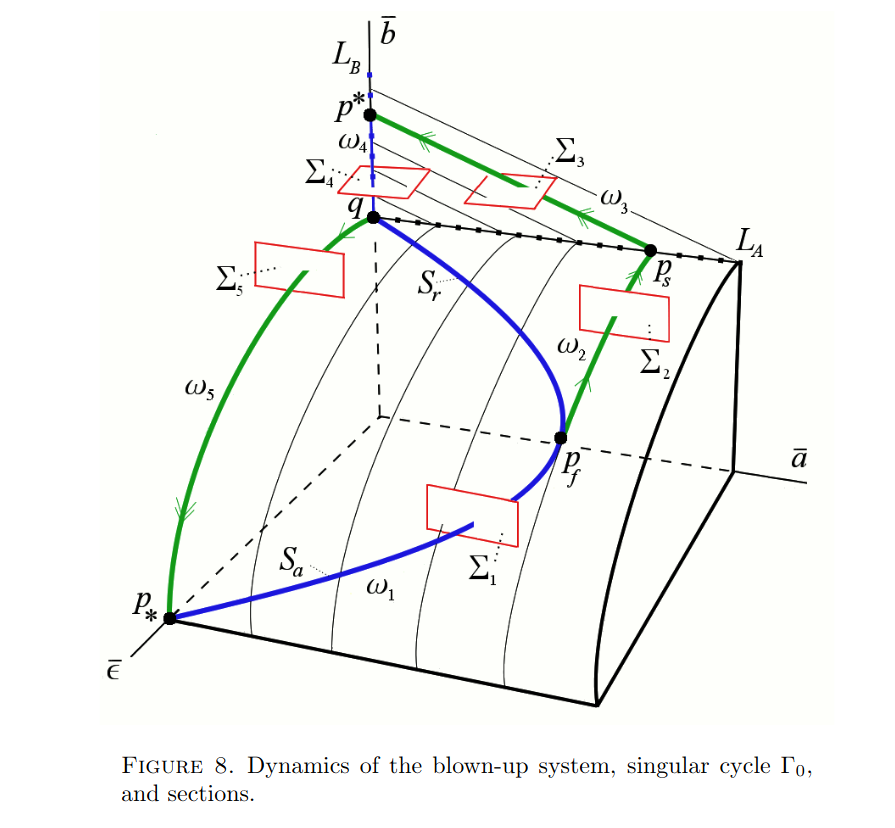

## IV. Canards

* Recall our favorite example, the van der Pol oscillator $$x' = x - \frac{x^3}{3} + y$$ $$y' = \epsilon\cdot(a-x)$$ Recall that we found a Hopf bifurcation at $a_{c} = 1$. Presence of a Hopf bifurcation dictates specific scaling of the emergent periodic orbit for $a$ very close to the bifurcation parameter $a_{c} = 1$; in particular, we expect small amplitude, roughly sinusoidal (i.e. uniform angular speed) oscillations.

* However, we found that the characteristic oscillations of the van der Pol oscillator are large amplitude with nonuniform slow and fast phases; these relaxation oscillations are very different from what the Hopf bifurcation predicts in a neighborhood of $a_{c}$

* **Q:** As the bifurcation parameter $a$ is varied, how do the periodic orbits of the van der Pol oscillator transition from small amplitude, uniform speed sinusoidal oscillations predicted by Hopf bifurcation to the large amplitude, nonuniform relaxation oscillations observed for a "typical" choice of $a$? 

* Let's do some numerical experiments.



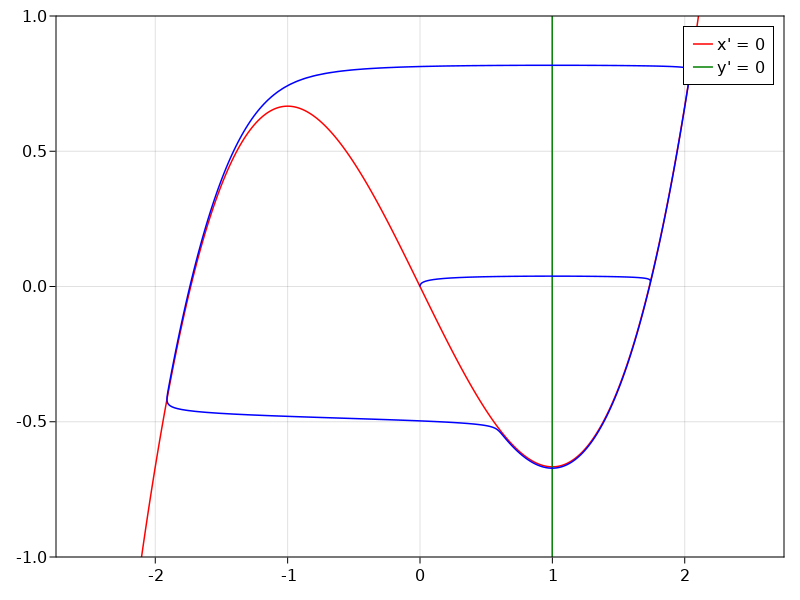

In [63]:
u0 = zeros(2)
tspan = (0.0,20.0)
p = (1e-2, canard_a)
fig, sol = vdpplot(u0,tspan,p)
fig

* Suggests the existence of periodic orbits that, quite surprisingly, hug the _repelling_ branch of the critical manifold! However, they appear to be extremely rare, only occurring for a very small range of parameters just below $a_{c} = 1.0$. Indeed, these special solutions, **canards**, do exist. It is possible to prove their existence using blowup techniques, in addition to several other approaches that appear in the literature (e.g. asymptotic analysis, nonstandard analysis, etc).

* However, canards are shown to exist for an _exponentially small_ range of parameter values, i.e. an interval with length on the order of $\text{exp}(-K/\epsilon)$ for some constant $K$. Thus, while interesting, we cannot really expect them to appear in applications. Relaxation oscillations discovered by chemists were actually said to exhibit a hard transition from small amplitude sinusoidal to large amplitude relaxation oscillations, due to the unobservability of the canard solutions.

**Q:** So are canards just a mathematical curiosity? 

**A:** _No._ Although canards only appear in exponentially small parameter intervals for _planar_ systems, higher dimensional systems can exhibit canards in large portions of parameter space. Moreover, the canards organize the phase space in interesting, unexpected ways.

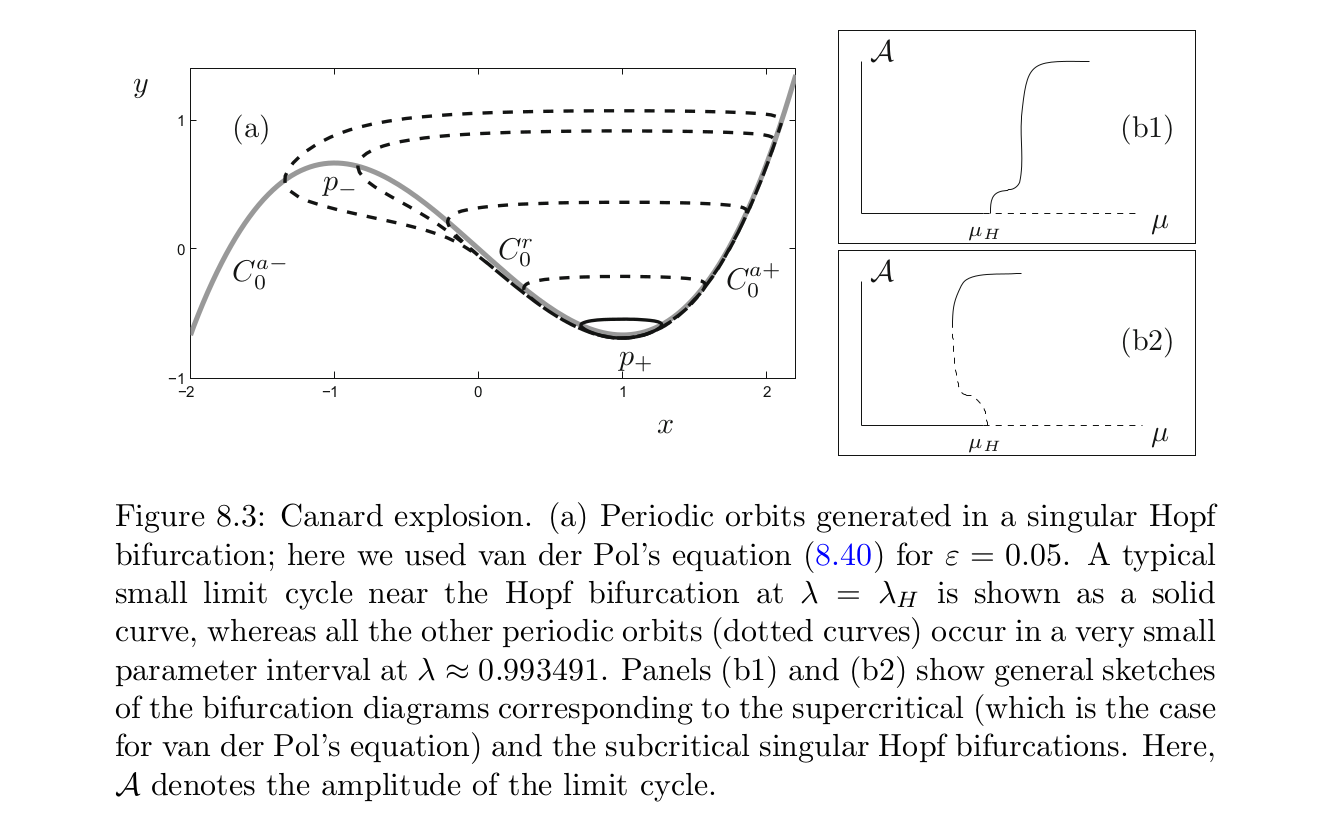